In [ ]:
#https://www.kaggle.com/sentdex/data-science-bowl-2017/first-pass-through-data-w-3d-convnet

## Imports

In [1]:
import dicom # for reading dicom files
import os # for doing directory operations 
import pandas as pd # for some simple data analysis (right now, just to load in the labels data and quickly reference it)
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
# Change this to wherever you are storing your data:
# IF YOU ARE FOLLOWING ON KAGGLE, YOU CAN ONLY PLAY WITH THE SAMPLE DATA, WHICH IS MUCH SMALLER
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.optimizers import SGD, RMSprop, Adam

#data_dir = '/datadrive/kaggle_ds_bowl_17/sample/'
data_dir = '/datadrive/kaggle_ds_bowl_17/stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('/datadrive/kaggle_ds_bowl_17/stage1_labels.csv', index_col=0)

labels_df.head()

/home/ubuntu/.local/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


## development

In [2]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices),label)
    print(slices[0])

(121, 0)
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.195528082086804571584870545115925581839
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: 'c02daa2116b27ce9b023fe7809ef5be9'
(0010, 0020) Patient ID                          LO: 'c02daa2116b27ce9b023fe7809ef5be9'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.89538356823739070703055979449661239495021598756041173087983
(0020, 000e) Series Instance UID                 UI: 2.25.23097173792577898856769568217830251219053331193695720690917
(0020, 0011) Series Number                       IS: '2'
(0020, 0012) Acquisition Number   

In [5]:
len(labels_df)

1397

In [3]:
for patient in patients[:3]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(slices[0].pixel_array.shape, len(slices))

((512, 512), 121)


KeyError: 'eb9db3f740f8e153e85f83c57bc4e522'

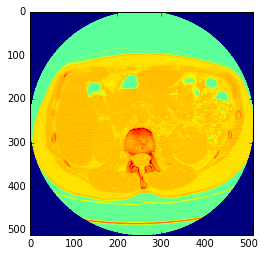

In [6]:


for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    #          the first slice
    plt.imshow(slices[0].pixel_array)
    plt.show()

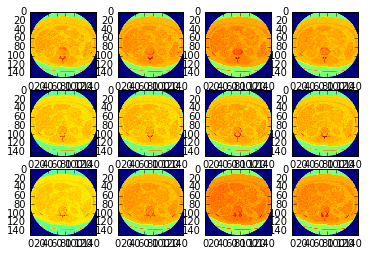

In [7]:

IMG_PX_SIZE = 150

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

In [53]:
import math

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l) / len(l)

IMG_PX_SIZE = 150
HM_SLICES = 20

data_dir = '/datadrive/kaggle_ds_bowl_17/stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('/datadrive/kaggle_ds_bowl_17/stage1_labels.csv', index_col=0)
for patient in patients[:15]:
    try:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        chunk_sizes = int(math.ceil(len(slices) / HM_SLICES))
        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        print(len(slices), len(new_slices))
    except:
        # some patients don't have labels, so we'll just pass on this for now
        print 'got err'

(121, 21)
got err
(240, 20)
(162, 21)
got err
(145, 21)
(174, 22)
(196, 22)
got err
(331, 21)
(127, 22)
(121, 21)
(151, 22)
(251, 21)
(130, 22)


In [25]:
for patient in patients[:10]:
    try:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]

        chunk_sizes = int(math.ceil(len(slices) / HM_SLICES))


        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        print(len(slices), len(new_slices))
    except Exception as e:
        # again, some patients are not labeled, but JIC we still want the error if something
        # else is wrong with our code
        print(str(e))

(121, 20)
'eb9db3f740f8e153e85f83c57bc4e522'
(240, 20)
(162, 20)
'8b494d14d835dd5ae13dab19b9520a55'
(145, 20)
(174, 20)
(196, 20)
'48ab0b98fc7789304c21430978624f32'
(331, 20)


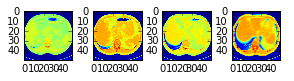

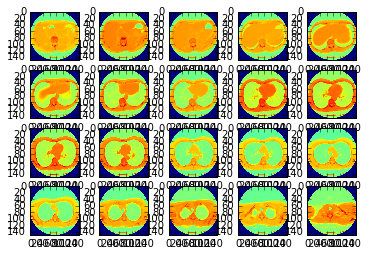

In [74]:


IMG_PX_SIZE = 150
HM_SLICES = 20

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []

    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = int(math.ceil(len(slices) / HM_SLICES))
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    
    fig = plt.figure()
    for num,each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice)
    plt.show()

In [112]:
% cd /datadrive/kaggle_ds_bowl_17/

/datadrive/kaggle_ds_bowl_17


## actual stuff

In [7]:
patients

['c02daa2116b27ce9b023fe7809ef5be9',
 'eb9db3f740f8e153e85f83c57bc4e522',
 'f39dacd5f134f3f4482094d3f8a0aff1',
 '504e447ad62ea9ebb283873e044b5dd2',
 '8b494d14d835dd5ae13dab19b9520a55',
 '402a18fa05523f80abb1e6d97793cc19',
 'e3e518324e1a85b85f15d9127ed9ea89',
 '39dc5f09d7b8eeda7f2f02c86f53247d',
 '48ab0b98fc7789304c21430978624f32',
 '7b43882369098df840e51421e6059aea',
 '6828335aec9aa0d0053ec0949319aa4b',
 'ad5f3a8ee73c1ff4cf401746be3bd493',
 'f4bee414210374e68b6746f70b38d461',
 '11616de262f844e6542d3c65d9238b6e',
 'c0625c79ef5b37e293b5753d20b00c89',
 'd73fda3be1180e4465df6fbef8a0648d',
 '608a7028689c6ab3aea5f116007169b2',
 '3c5a0fc6890a1f84211cf8a75c1b83c4',
 'cec6819833f63e96fc3e17e29c0124f8',
 'de635c85f320131ee743733bb04e65b9',
 'bfb3e2d11c149036bbe12566ef6b933c',
 'fdcd385b0d2d12341661e1abe845be0b',
 '8d5c4cc78e964463699c19003be70851',
 'cc24c86f88a9d17c04255a4d264030e6',
 '975f7f3c5bad9e9f0bc31e723fd6f793',
 'fb99a80cbb2f441bb90135bab5b029fe',
 'b8bb02d229361a623a4dc57aa0e5c485',
 

In [8]:
label = labels_df.get_value(patients[0], 'cancer')
path = data_dir + patients[0]
slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

In [10]:
len(slices)

121

In [229]:
image_codes

array([45,  3, 33, 21, 19])

121
[45 11 22 34  5]


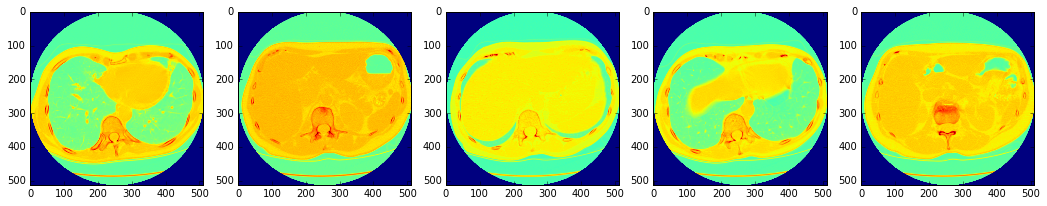

In [234]:
i=0
#print label
patient_sample=np.random.choice(range(1000),5)
#for i in patient_sample:
print len(slices)
fig = plt.figure( figsize=(18, 6))

image_codes=np.random.choice(range(len(slices)),5)
print image_codes
for num,each_slice in enumerate(np.array(slices)[image_codes]):

    z = fig.add_subplot(1,5,num+1)
    pass
    z.imshow(each_slice.pixel_array)
plt.show()

0
0


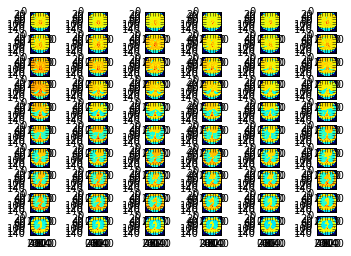

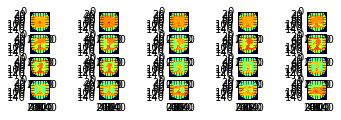

This is unlabeled data!
0


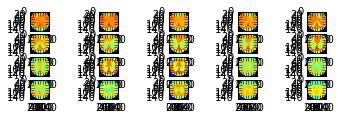

1


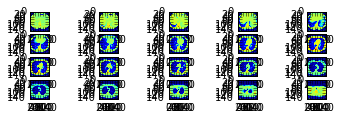

This is unlabeled data!
0


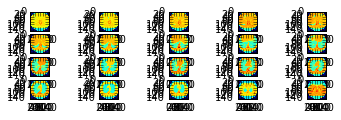

0


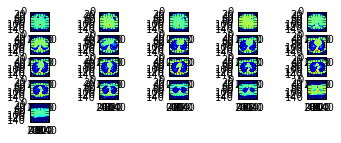

0


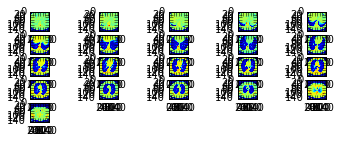

This is unlabeled data!
0


KeyboardInterrupt: 

In [136]:


IMG_SIZE_PX = 150
SLICE_COUNT = 20

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)


def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=True):
    
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    
    chunk_sizes = int(math.ceil(len(slices) / hm_slices))
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices)<hm_slices:
        for i in range(hm_slices-len(new_slices)):
            new_slices.append(new_slices[-1])
            
    while len(new_slices)>hm_slices:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        print label
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(10,5,num+1)
            pass
            y.imshow(each_slice)
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

#                                               stage 1 for real.
data_dir = '/datadrive/kaggle_ds_bowl_17/stage1/'
#patients = os.listdir(data_dir)
labels = pd.read_csv('/datadrive/kaggle_ds_bowl_17/stage1_labels.csv', index_col=0)

much_data = []
for num,patient in enumerate(patients):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')

np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)

In [12]:
% cd /datadrive/kaggle_ds_bowl_17/

/datadrive/kaggle_ds_bowl_17


In [13]:
import numpy as np
#much_data=np.load('/datadrive/kaggle_ds_bowl_17/muchdata-150-150-50.npy')
much_data=np.load('muchdata-50-50-20.npy')

In [21]:
for obj in much_data:
    print obj[0].shape
    break

(20, 50, 50)


In [24]:
obj[0][obj[0] == -2000] = 0

In [25]:
np.mean(obj[0])

448.72469999999998

## tensorflow model

In [82]:
import tensorflow as tf
import numpy as np

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),#    5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),#   64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [95]:
import numpy as np

much_data = np.load('muchdata-50-50-20.npy')
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:-100]
validation_data = much_data[-100:]


#def train_neural_network(x):
prediction = convolutional_neural_network(x)
cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

hm_epochs = 10
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())

    successful_runs = 0
    total_runs = 0

    for epoch in range(hm_epochs):
        epoch_loss = 0
        for data in train_data:
            #print data[0].shape
            if data[0].shape[0]==20:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))

        print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))

    print('Done. Finishing accuracy:')
    print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))

    print('fitment percent:',successful_runs/total_runs)

# Run this locally:
#train_neural_network(x)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 1, 'completed out of', 10, 'loss:', 264891673381.75)


ValueError: setting an array element with a sequence.

## Keras Model

In [33]:
% cd /home/ubuntu/Notebooks/kaggle_ds_bowl_17/

/home/ubuntu/Notebooks/kaggle_ds_bowl_17


In [26]:
X=np.array([i[0] for i in much_data])
y=np.array([i[1] for i in much_data])

In [28]:
#bcz this -2000 is actually 0...
X[X == -2000] = 0

In [29]:
X=X.reshape(X.shape[0],1,X.shape[1],X.shape[2],X.shape[3])

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.15, random_state=42)

In [34]:

from cancer_utils import get_model_3dconv

model=get_model_3dconv(summary=True)
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
def get_model_3dconv_2():
    model = Sequential()
    # 1st layer group
    model.add(Convolution3D(64, 5, 5, 5, activation='relu', border_mode='same', name='conv1',subsample=(1, 1, 1), input_shape=(1, 20, 50, 50)))    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), border_mode='valid', name='pool1'))
    
    model.add(Convolution3D(128, 3, 3, 3, activation='relu', border_mode='same', name='conv2', subsample=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2),  border_mode='valid', name='pool2'))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', name='fc7'))
    #model.add(Dropout(.5))
    model.add(Dense(1024, activation='relu', name='fc8'))
    #model.add(Dropout(.5))
    model.add(Dense(2, activation='softmax', name='fc'))
    return model

model=get_model_3dconv_2()
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.fit(X_train,y_train,nb_epoch=3,validation_data=(X_val,y_val))

Train on 1187 samples, validate on 210 samples
Epoch 1/3
1187/1187 [==============================] - 4s - loss: 4.1144 - acc: 0.7447 - val_loss: 4.5284 - val_acc: 0.7190

In [ ]:
#todo:
#1. split to vlaidation, perhaps some kind of cross
#2 try to improve slightly to submit
#3 submit
#4 try to imprvoe more than slightly - watch  images etc

In [39]:
#normlize
mean=X_train.mean()
X_train=X_train-mean
std=X_train.std()
X_train=X_train/std

816
[16  2 44 49 26]


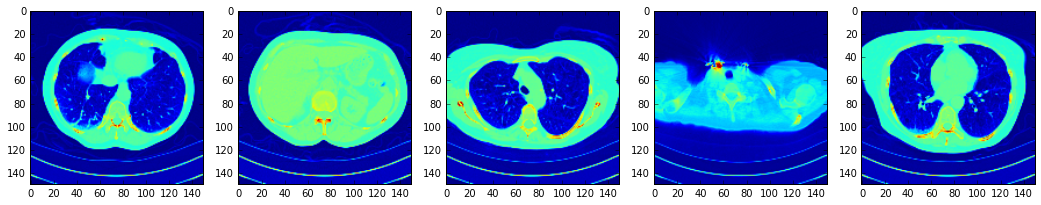

2
[16 39 47 16 21]


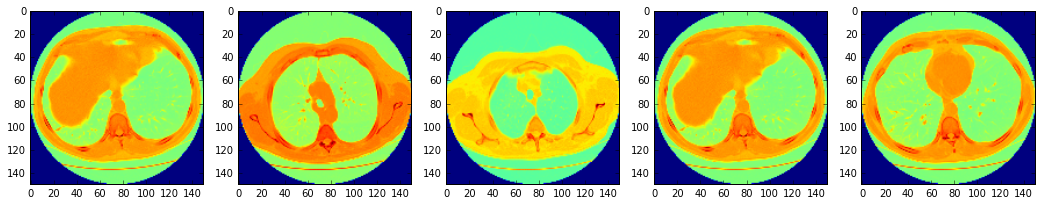

959
[ 2  3 26 29 39]


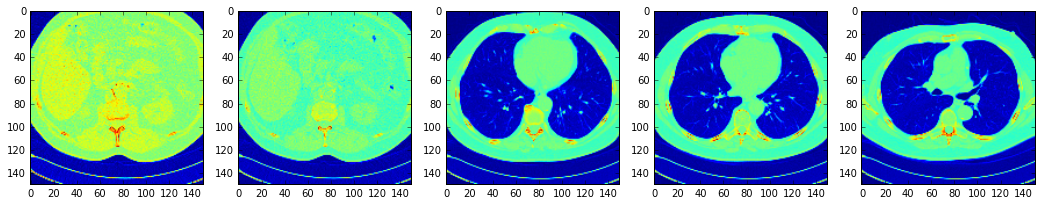

184
[12  6 42  4 38]


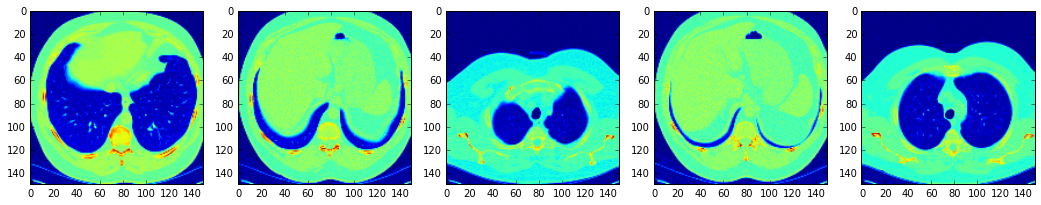

400
[16 20 20  9 31]


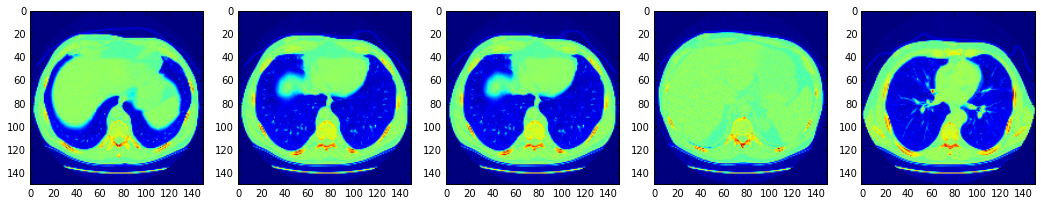

In [212]:

#print label
patient_sample=np.random.choice(range(1000),5)
for i in patient_sample:
    print i
    fig = plt.figure( figsize=(18, 6))
    patient=X_train[i]
    image_codes=np.random.choice(range(50),5)
    print image_codes
    for num,each_slice in enumerate(patient[0][image_codes]):
        
        z = fig.add_subplot(1,5,num+1)
        pass
        z.imshow(each_slice)
    plt.show()